## The colab part is mainly used to obtain results for whisper. For preprocessing, we run it on jupyterlab

In [1]:
# installing on colab
pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 18.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=25bee514fdeebd76412d238bf66b7fb47969dfe5b7d5c7e8fc922917b3eda29e
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


## Colab is mainly used to speed up the transcription of Whisper data. For transcription at each temperature it took 2-3 hours.

In [62]:
import os
import json
import whisper

In [79]:
from num2words import num2words
from nltk.corpus import cmudict
cmu_dict = cmudict.dict()
import math
import string

In [3]:
# files for downloading
from google.colab import files

In [4]:
model = whisper.load_model('base.en')

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 54.0MiB/s]


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Using the base directory to generate a list of filenames, and full filepaths
def file_names_paths(mooc_base_dir):
    mooc_folders = os.listdir(mooc_base_dir) # display all filenames
    mooc_subfolders=[] # the paths of base dir plus word name
    for item in mooc_folders:
        if not item.endswith('.DS_Store'):
            audio = os.path.join(mooc_base_dir,item)
            mooc_subfolders.append(audio)
    mooc_fnl_subfolders = sorted(mooc_subfolders)# starting from 1, and sorted, so DS. not displayed
    mooc_filenames = []
    mooc_filepaths = []
    flatten_mooc_filenames = []
    for subfolder in mooc_fnl_subfolders:
        mooc_filepath= sorted(os.listdir(subfolder))
        for item in mooc_filepath:
            full_path = os.path.join(subfolder, item)
            mooc_filepaths.append(full_path)
            flatten_mooc_filenames.append(item)
    return flatten_mooc_filenames, mooc_filepaths

In [9]:
# Count the intelligibel and unintelligible distribution
mooc_base_dir = "/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio"
flatten_mooc_filenames, mooc_filepaths = file_names_paths(mooc_base_dir)
def count_labels(mooc_filenames):
    intelligible_count = 0
    unintelligible_count = 0
    for x in mooc_filenames:
        if x.endswith('1.mp3'):
            intelligible_count += 1
        else:
            unintelligible_count += 1
    print(f'There are {intelligible_count} "intelligible" labels,')
    print(f'and {unintelligible_count } "unintelligible" labels')
    return

In [10]:
# Inspecting
print(len(flatten_mooc_filenames))
print(flatten_mooc_filenames[0:5])
print(mooc_filepaths[0:5])

10230
['series01-s00000-Paul-1.mp3', 'series01-s000011-Paul-0.mp3', 'series01-s000012-Paul-1.mp3', 'series01-s000013a-Paul-0.mp3', 'series01-s000013b-Paul-0.mp3']
['/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio/Paul/series01-s00000-Paul-1.mp3', '/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio/Paul/series01-s000011-Paul-0.mp3', '/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio/Paul/series01-s000012-Paul-1.mp3', '/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio/Paul/series01-s000013a-Paul-0.mp3', '/content/gdrive/MyDrive/Colab Notebooks/file/mooc_audio/Paul/series01-s000013b-Paul-0.mp3']


In [11]:
# Calling to show the overall distribution of intelligible and unintelligible labels
count_labels(flatten_mooc_filenames)

There are 5726 "intelligible" labels,
and 4504 "unintelligible" labels


In [12]:
# Splitting the filenames and filepaths into equal distributions of test and dev
def testdev_split(a, b):
    dev_filenames = []
    test_filenames = []
    dev_filepaths = []
    test_filepaths = []
    for (i_filename, filename), (i_filepath, filepath) in zip(enumerate(a),enumerate(b)):
        if i_filename%2 == 0:
            dev_filenames.append(filename)
        elif i_filename%2 == 1:
            test_filenames.append(filename)
    #for i, filepath in enumerate(b):
        if i_filepath%2 == 0:
            dev_filepaths.append(filepath)
        elif i_filepath%2 == 1:
            test_filepaths.append(filepath)
    return dev_filenames, test_filenames, dev_filepaths, test_filepaths


In [13]:
# providing the dev and test filenames and full file paths for the task
dev_fn, test_fn, dev_fp, test_fp = testdev_split(flatten_mooc_filenames, mooc_filepaths)

## best-of method in whisper transcription to select the 20 results (some overlap) and then unique transcript will later be selected and counted

In [15]:
def whisper_top_res(audio_file, temperature):
    audiosamp=whisper.load_audio(audio_file)
    audiosamp=whisper.pad_or_trim(audiosamp) #pad/trim it to fit 30 seconds
    mel = whisper.log_mel_spectrogram(audiosamp).to(model.device)
    options = whisper.DecodingOptions(language="en", temperature=temperature, best_of=1)
    result = whisper.decode(model, mel, options)

    num_samples = 20
    res_list= []
    scores = []
    for _ in range(num_samples):
        result = whisper.decode(model, mel, options)
        scores.append(result.avg_logprob)
        res_list.append({'text':result.text, 'avg_logprob':result.avg_logprob})

    return res_list


In [16]:
file_xample = '/content/gdrive/MyDrive/Colab Notebooks/file/dummy_temp/s03_paw_1.mp3'


In [17]:
whisper_top_res(file_xample, 0.4)

[{'text': 'Go.', 'avg_logprob': -1.3301070213317872},
 {'text': 'Both.', 'avg_logprob': -1.302091121673584},
 {'text': 'Paul?', 'avg_logprob': -1.2505410194396973},
 {'text': 'Go!', 'avg_logprob': -1.3203139305114746},
 {'text': 'Bo.', 'avg_logprob': -1.2733623504638671},
 {'text': 'Go.', 'avg_logprob': -1.2308309555053711},
 {'text': 'Bo.', 'avg_logprob': -1.2733623504638671},
 {'text': 'ball.', 'avg_logprob': -2.141057777404785},
 {'text': 'Go!', 'avg_logprob': -1.3203139305114746},
 {'text': 'Bo.', 'avg_logprob': -1.3235505104064942},
 {'text': 'Bo.', 'avg_logprob': -1.3235505104064942},
 {'text': 'Bo.', 'avg_logprob': -1.5094337463378906},
 {'text': 'Bo.', 'avg_logprob': -1.2733623504638671},
 {'text': 'for', 'avg_logprob': -1.2418733835220337},
 {'text': 'Both.', 'avg_logprob': -1.302091121673584},
 {'text': 'Pull.', 'avg_logprob': -1.4525264739990233},
 {'text': 'Go.', 'avg_logprob': -1.2308309555053711},
 {'text': 'Bo.', 'avg_logprob': -1.2733623504638671},
 {'text': 'Bo.', 'avg

In [18]:
# Function to transcribe audio files in a specific folder and save the transcriptions to JSON files
def mooc_multi_whisper_transcribe_audio_folder(filenames, filepaths, temperature, transcriptions_info_path, raw_text_path):
    raw_text = {}
    transcriptions_info = {}

    for filename, filepath in zip(filenames, filepaths):
        if filename.endswith(".mp3"):    # Remove '.mp3' extension from the filename
            base_filename = filename[:-4]
            parts = base_filename.split('-') # Split filename to extract studentID, word, and trueLabel
            studentID = parts[0] + '-' + parts[1]
            word = parts[2]
            trueLabel = 'intelligible' if parts[3] == '1' else 'unintelligible'

            result = whisper_top_res(filepath, temperature) # HERE TEMPERATURE SHOULD BE GIVEN
            segments_info = []  # Extract required fields from all segments
            segment_info = {
                    "text and avg_logprob": result # to differ from the 'text_one' since here we have mulitple in a list
                    }
            segments_info.append(segment_info)

            transcriptions_info[base_filename] = {
                "studentID": studentID,
                "word": word,
                "trueLabel": trueLabel,
                "segments": segments_info
            }

            raw_text[base_filename] = result
    #return transcriptions_info, raw_text
    with open(transcriptions_info_path, 'w') as json_file: #and save the detailed transcriptions info to a JSON file
        json.dump(transcriptions_info, json_file, indent=4)
    print(f"Transcription info saved to {transcriptions_info_path}")

    with open(raw_text_path, 'w') as json_file: # Save the raw transcriptions to a JSON file
        json.dump(raw_text, json_file, indent=4)
    print(f"Raw transcription saved to {raw_text_path}")

## given the limit of google colab on session time and time taken, transcribing batches at severel temperature values at one time is not viable. Therefore, it is done at one temperature per session

In [19]:
# TESTING with a small number of data at temperature 0.4
dum_filepaths = mooc_filepaths[0:10]
dum_filenames = flatten_mooc_filenames [0:10]
dum_transcriptions_info_path04 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/multi_raw_info_result_whisper04.json'
dum_raw_text_path04 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/multi_raw_text_result_whisper04.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(dum_transcriptions_info_path04), exist_ok=True)
os.makedirs(os.path.dirname(dum_raw_text_path04), exist_ok=True)
# Calling
mooc_multi_whisper_transcribe_audio_folder(dum_filenames, dum_filepaths, 0.4, dum_transcriptions_info_path04, dum_raw_text_path04)

Transcription info saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/multi_raw_info_result_whisper04.json
Raw transcription saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/multi_raw_text_result_whisper04.json


In [ ]:
# calling dev at temperature 0.1
# filenames for development: dev_fn
#file paths for development: dev_fp
whisper_transcriptions_info_path01 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper01_raw_info_result.json'
whisper_raw_text_path01 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper01_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(whisper_transcriptions_info_path01), exist_ok=True)
os.makedirs(os.path.dirname(whisper_raw_text_path01), exist_ok=True)
# Calling
mooc_multi_whisper_transcribe_audio_folder(dev_fn, dev_fp, 0.1, whisper_transcriptions_info_path01, whisper_raw_text_path01)

In [ ]:
files.download(whisper_transcriptions_info_path01)
files.download(whisper_raw_text_path01)
# downloaded; took 3 hrs to run one

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calling dev at temperature 0.3
whisper_transcriptions_info_path03 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper03_raw_info_result.json'
whisper_raw_text_path03 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper03_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(whisper_transcriptions_info_path03), exist_ok=True)
os.makedirs(os.path.dirname(whisper_raw_text_path03), exist_ok=True)

mooc_multi_whisper_transcribe_audio_folder(dev_fn, dev_fp, 0.3, whisper_transcriptions_info_path03, whisper_raw_text_path03)

In [ ]:
files.download(whisper_transcriptions_info_path03)
files.download(whisper_raw_text_path03)
## downloaded; took 3 hrs to run one

In [ ]:
# Calling at temperature 0.5
whisper_transcriptions_info_path05 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper05_raw_info_result.json'
whisper_raw_text_path05 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper05_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(whisper_transcriptions_info_path05), exist_ok=True)
os.makedirs(os.path.dirname(whisper_raw_text_path05), exist_ok=True)

mooc_multi_whisper_transcribe_audio_folder(dev_fn, dev_fp, 0.5, whisper_transcriptions_info_path05, whisper_raw_text_path05)

In [ ]:
files.download(whisper_transcriptions_info_path05)
files.download(whisper_raw_text_path05)


In [ ]:
# Calling at temperature 0.7
whisper_transcriptions_info_path07 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper07_raw_info_result.json'
whisper_raw_text_path07 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper07_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(whisper_transcriptions_info_path07), exist_ok=True)
os.makedirs(os.path.dirname(whisper_raw_text_path07), exist_ok=True)

mooc_multi_whisper_transcribe_audio_folder(dev_fn, dev_fp, 0.7, whisper_transcriptions_info_path07, whisper_raw_text_path07)

Transcription info saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper07_raw_info_result.json
Raw transcription saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper07_raw_text_result.json


In [ ]:
files.download(whisper_transcriptions_info_path07)
files.download(whisper_raw_text_path07)
##downloaded, took 2.20hrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calling at temperature 0.9

whisper_transcriptions_info_path09 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper09_raw_info_result.json'
whisper_raw_text_path09 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper09_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(whisper_transcriptions_info_path09), exist_ok=True)
os.makedirs(os.path.dirname(whisper_raw_text_path09), exist_ok=True)

mooc_multi_whisper_transcribe_audio_folder(dev_fn, dev_fp, 0.9, whisper_transcriptions_info_path09, whisper_raw_text_path09)

Transcription info saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/whisper09_raw_info_result.json
Raw transcription saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/whisper09_raw_text_result.json


In [ ]:
files.download(whisper_transcriptions_info_path09)
files.download(whisper_raw_text_path09)
##

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the JSON data from a file
def load_json(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

# Preprocesses the text by removing leading spaces and punctuations, and converting to lowercase.
def preprocess_text(text):
    text = text.strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

# Convert numbers to words if necessary
def convert_number_to_word(text):
    words = text.split()
    converted_words = []
    for word in words:
        if word.isdigit():
            converted_word = num2words(int(word))  # Convert number to word
            converted_words.append(converted_word)
        else:
            converted_words.append(word)
    return ' '.join(converted_words)

# Function to retrieve phonetic representations from CMU Pronouncing Dictionary.
def get_phonetic_representation(word):
    phonetic_representations = cmu_dict.get(word.lower())
    if phonetic_representations:
        return ' '.join(phonetic_representations[0])  # Join the phonetic representations with space
    else:
        return 'N/A'  # Return 'N/A' if word not found in dictionary


### Preprocesses the segment texts and calculates the confidence score for each transcription -- modified version


In [65]:
def model_preprocess_and_calculate_multi(json_file_path):
    data = load_json(json_file_path)
    preprocessed_results = {}

    for key, value in data.items():
        studentID = value["studentID"]
        word = value["word"]
        trueLabel = value["trueLabel"]
        segments = value["segments"]
        true_transcription_stripped = convert_number_to_word(word)  # Convert true transcription to words if necessary
        true_phonetic_rep = get_phonetic_representation(true_transcription_stripped) # Get phonetic representations for both true and whisper's transcriptions
        # Preprocess text
        text_avglog_list = segments[0]["text and avg_logprob"]
        lst_model_transcription = []
        lst_true_phonetic_rep = []
        lst_model_phonetic_rep = []
        lst_model_judge_phonetic = []
        lst_confidence_scores = []
        for text in text_avglog_list: ## its a list of dictionary containing text and average log prob
            preprocessed_texts = []
            ## setting confidence score to 0 if len(SGM) >1
            ## SETTING CONFIDENCE SCORE TO 0 if there's no word
            if len(text['text']) == 0:
                confidence_score = 0
                preprocessed_texts.append('')
                print(f"No transcriptions for audio file: {studentID}_{word}")
            else:
                avg_logprob = text["avg_logprob"]
                confidence_score = round(math.exp(avg_logprob), 3)
                preprocessed_text = preprocess_text(text['text'])
                preprocessed_texts.append(preprocessed_text)

            lst_confidence_scores.append(confidence_score) # collecting confidence scores
            # Join and process text for all cases
            model_transcription = ' '.join(preprocessed_texts).strip()
            model_transcription = convert_number_to_word(model_transcription)  # Convert numbers to words if necessary
            lst_model_transcription.append(model_transcription)      # DECIDING NOT USE WHISPER_JUDGE;


            lst_true_phonetic_rep.append(true_phonetic_rep)
            model_phonetic_rep = get_phonetic_representation(model_transcription)
            lst_model_phonetic_rep.append(model_phonetic_rep)
            lst_topn=[]  ### NEW CONVERSION OF DATA FORMAT

            for a, b, d in zip(lst_model_transcription,lst_confidence_scores,lst_model_phonetic_rep):
                dict_new={'model_transcription':a,'confidence score':b,'model_phonetic_rep':d}
                lst_topn.append(dict_new)
 ### SPECIFIC TO WHISPER TO SELECT UNIQUE ONES
            lst_uniq_text = [] #unique text list
            filtered_lst_topn = [] # filtered item

            dummy_result={'model_transcription': 'N/A', 'confidence score': 0, 'model_phonetic_rep': 'N/A'} # To refill when a word has less than three unique results
            for item in lst_topn:
                if item['model_transcription'] not in lst_uniq_text:
                    lst_uniq_text.append(item['model_transcription'])
                    filtered_lst_topn.append(item)
 ### CHOOSING TOP THREE:
            if len(filtered_lst_topn) == 1:
                final_filtered_topn = [filtered_lst_topn[0],dummy_result,dummy_result] #Not every output has more than 3 results, we fill if any output is less than 3 with dummy_result
            if len(filtered_lst_topn) == 2:
                final_filtered_topn = [filtered_lst_topn[0],filtered_lst_topn[1],dummy_result]
            if len(filtered_lst_topn) >= 3:
                 final_filtered_topn = [filtered_lst_topn[0],filtered_lst_topn[1],filtered_lst_topn[2]]


        preprocessed_results[key] = {
            "studentID": studentID,
            "true_transcription": word,
            "trueLabel": trueLabel,
            "true_phonetic_rep":true_phonetic_rep,
            "uniq res": filtered_lst_topn,
            "top res": final_filtered_topn # ADPATED
            }

    return preprocessed_results

In [66]:
multi_whisper_transcription_info_07 =  "./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper07_raw_info_result.json"
# preprocess the json using multi_whisper_preprocess_and_calculate
whisper_multi_res07 = model_preprocess_and_calculate_multi(multi_whisper_transcription_info_07)

No transcriptions for audio file: series07-s00129_city
No transcriptions for audio file: series04-s00009_cot
No transcriptions for audio file: series04-s00015_meet


In [67]:
# inspecting an example of raw transcription
filexample = load_json(multi_whisper_transcription_info_07)
print(type(filexample))
for key, value in filexample.items():
    print(key)
    print(value)
    break

<class 'dict'>
series01-s00000-Paul-1
{'studentID': 'series01-s00000', 'word': 'Paul', 'trueLabel': 'intelligible', 'segments': [{'text and avg_logprob': [{'text': 'poll', 'avg_logprob': -1.392437219619751}, {'text': 'poll', 'avg_logprob': -1.8757894039154053}, {'text': 'Paul?', 'avg_logprob': -1.8223232269287108}, {'text': "I'm a...", 'avg_logprob': -3.1334122249058316}, {'text': 'Paul?', 'avg_logprob': -1.967156982421875}, {'text': 'Palm.', 'avg_logprob': -2.514944648742676}, {'text': 'Phone.', 'avg_logprob': -1.4076932907104491}, {'text': 'Phone.', 'avg_logprob': -1.8013404846191405}, {'text': 'Pawn.', 'avg_logprob': -1.9184025128682454}, {'text': 'Po.', 'avg_logprob': -2.200906753540039}, {'text': 'Poll.', 'avg_logprob': -1.5466182708740235}, {'text': 'Oh', 'avg_logprob': -1.5360673666000366}, {'text': 'poem', 'avg_logprob': -2.0536837577819824}, {'text': 'Paul', 'avg_logprob': -1.7002261877059937}, {'text': 'poll', 'avg_logprob': -1.63498055934906}, {'text': 'poll', 'avg_logprob':

In [68]:
# Inspecting collection of transcriptions
xam=[]
for key, value in whisper_multi_res07.items():
   # print (key)
    xam.append((value['uniq res']))
    print (value['top res'])
    break


[{'model_transcription': 'poll', 'confidence score': 0.248, 'model_phonetic_rep': 'P OW1 L'}, {'model_transcription': 'paul', 'confidence score': 0.162, 'model_phonetic_rep': 'P AO1 L'}, {'model_transcription': 'im a', 'confidence score': 0.044, 'model_phonetic_rep': 'N/A'}]


In [69]:
# obtain process output of transcription
list_of_raw_info = ["./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper01_raw_info_result.json",
                   "./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper03_raw_info_result.json",
                   "./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper05_raw_info_result.json",
                   "./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper07_raw_info_result.json",
                   "./tst_json_files/transcription_output/whisper_raw_transcription_info/whisper09_raw_info_result.json"]

list_of_output_json_file = ["./tst_json_files/transcription_output/whisper_processed_output/whisper01_output.json",
                            "./tst_json_files/transcription_output/whisper_processed_output/whisper03_output.json",
                            "./tst_json_files/transcription_output/whisper_processed_output/whisper05_output.json",
                            "./tst_json_files/transcription_output/whisper_processed_output/whisper07_output.json",
                            "./tst_json_files/transcription_output/whisper_processed_output/whisper09_output.json"
                           ]


In [70]:
#CALLING
for raw_info, output_json_file in zip(list_of_raw_info, list_of_output_json_file):
    result = model_preprocess_and_calculate_multi(raw_info)
    with open(output_json_file, 'w') as json_file:
        json.dump(result, json_file, indent=4)
    print(f"Preprocessed results saved to {output_json_file}")

Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/whisper01_output.json
Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/whisper03_output.json
No transcriptions for audio file: series06-s00017_knows
No transcriptions for audio file: series05-s000073_seedy
Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/whisper05_output.json
No transcriptions for audio file: series07-s00129_city
No transcriptions for audio file: series04-s00009_cot
No transcriptions for audio file: series04-s00015_meet
Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/whisper07_output.json
No transcriptions for audio file: series07-s00008_bard
No transcriptions for audio file: series07-s00063_bear
No transcriptions for audio file: series03-s0000128_beer
No transcriptions for audio file: series04-s00028_boy
No transcriptions for audio file: series07

In [71]:
# A FUNCTION TO FILTER NUMBER OF RESULTS USING PROCESSED RESULTS
def filter_topn(whisper_multi_res):
    collection_transcript = []
    for key, value in whisper_multi_res.items():
        collection_transcript.append(value['top res'])
    fnl_unique=[]
    fnl_lst_full=[]
    freq_lst=[]
    for collection_lst in collection_transcript:
        lst_unique=[]
        lst_full=[]
        for item in collection_lst:
            if item['model_transcription'] not in lst_unique:
                lst_unique.append(item['model_transcription'])
                lst_full.append(item)
        #fnl_unique.append((len(lst_unique),lst_unique))
        fnl_lst_full.append((len(lst_full),lst_full))
        freq_lst.append(len(lst_full))
    return fnl_lst_full, freq_lst

In [72]:
fnl_lst04,freq_lst04 =filter_topn(whisper_multi_res07) # TRYING TO PRINT THE TOP N RESULT OF EACH AUDIO

print(fnl_lst04[34])

In [73]:
items = freq_lst04
counts = {item: items.count(item) for item in set(items)}
print(counts)

{2: 686, 3: 4429}


### Below is the result of how many unique transcrptions are distributed among the transcription at each temperature; for instance at temperature 0.1, there are 3869 results that only have one unique hypothesis , and 946 that have two hypotheses

#### Based on the distrubition, I decide to choose 0.3, 0.5 and 0.7 as three temperatures, and selet top 3 unique hypotheses. Moreover, since there are 686-2379 instances where only one hypothesis is available, I add the close to last hypothesis to fill them to 3 hypotheses.


In [ ]:
# tem_data: temp_0x is the temperature. within the value, a key is the number of unique results and value is the quantity
tem_data = {'temp_01': {1: 3869, 2: 946, 3: 217, 4: 58, 5: 16, 6: 6, 7: 1, 10: 2},
        'temp_03': {1: 2379, 2: 1257, 3: 645, 4: 379, 5: 209, 6: 102, 7: 63, 8: 35, 9: 23, 10: 11, 11: 5, 13: 4, 15: 1, 16: 1, 18: 1},
        'temp_05': {1: 1398, 2: 1057, 3: 758, 4: 554, 5: 365, 6: 285, 7: 235, 8: 139, 9: 113, 10: 72, 11: 51, 12: 33, 13: 22, 14: 16, 15: 5, 16: 8, 17: 1, 18: 3},
        'temp_07': {1: 686, 2: 706, 3: 653, 4: 534, 5: 421, 6: 386, 7: 359, 8: 290, 9: 237, 10: 209, 11: 177, 12: 137, 13: 88, 14: 80, 15: 54, 16: 47, 17: 27, 18: 9, 19: 10, 20: 5},
        'temp_09': {1: 170, 2: 268, 3: 389, 4: 354, 5: 371, 6: 343, 7: 374, 8: 350, 9: 347, 10: 308, 11: 286, 12: 270, 13: 258, 14: 231, 15: 222, 16: 194, 17: 142, 18: 112, 19: 77, 20: 49}
        }

In [ ]:
import matplotlib.pyplot as plt # importing tools for visualisation
import pandas as pd

In [ ]:
# Aggregating into bins 1, 2, 3, and 4+
def whisper_unique_temp(data, filename):
    aggregated = {}
    for key, values in data.items():
        agg = {
        "1": values.get(1, 0),
        "2": values.get(2, 0),
        "3": values.get(3, 0),
        "4+": sum(v for k, v in values.items() if k >= 4)
        }
        aggregated[key] = agg

    df = pd.DataFrame(aggregated).T

    df.plot(kind="bar", figsize=(10, 6)) #Plotting
    plt.title("Distribution of Temps across categories (1, 2, 3, 4+)")
    plt.xlabel("Temperatures")
    plt.ylabel("Frequency")
    plt.legend(title="Num Uniq Hypotheses")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"./graphs/{filename}", bbox_inches='tight') # save the figure
    plt.show()


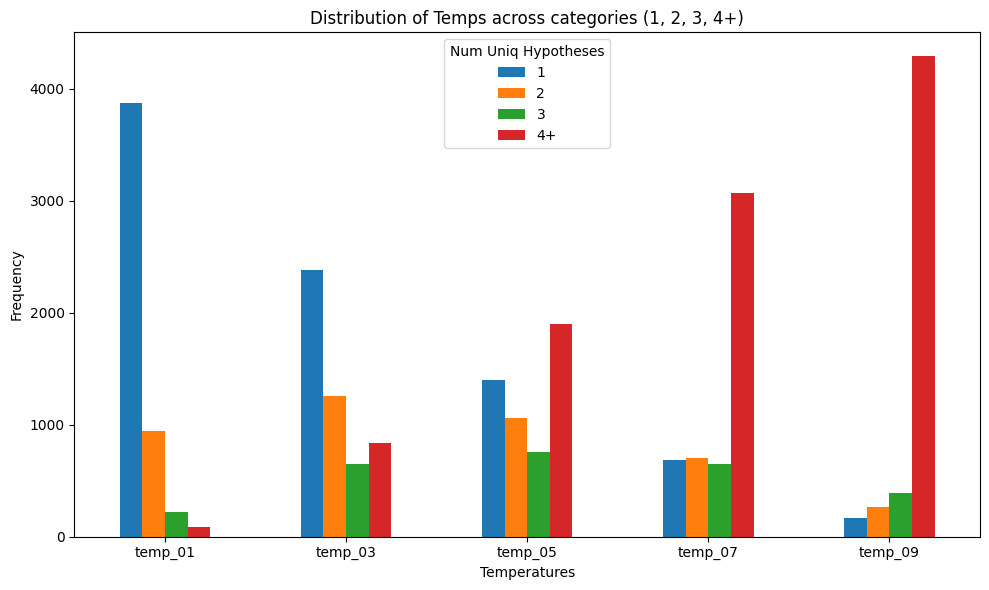

In [ ]:
# calling
whisper_unique_temp(tem_data,'distribution_unique_hypo_temps')

### For the testfiles we use colab again to obtain predictions

In [21]:
# For testing file we choose temperature at 0.7
test_whisper_transcriptions_info_path07 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/test_whisper07_raw_info_result.json'
test_whisper_raw_text_path07 = 'content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/test_whisper07_raw_text_result.json'
# Create directories if they don't exist
os.makedirs(os.path.dirname(test_whisper_transcriptions_info_path07), exist_ok=True)
os.makedirs(os.path.dirname(test_whisper_raw_text_path07), exist_ok=True)
# Calling
mooc_multi_whisper_transcribe_audio_folder(test_fn, test_fp, 0.7, test_whisper_transcriptions_info_path07, test_whisper_raw_text_path07)

Transcription info saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/test_whisper07_raw_info_result.json
Raw transcription saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/test_whisper07_raw_text_result.json


In [22]:
# took 2 hours 40 mins
files.download(test_whisper_transcriptions_info_path07)
files.download(test_whisper_raw_text_path07)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Here we test Furong's data, so we need to obtain raw text and transcription information at 0.7 temperature for both development and test data. In comparison with data size of my thesis, the previous is about 1/10 the size

In [74]:
# we first adapt the transcribe file function
## we need to use Furong's code and adapted the 'transcribe' into 'whisper_top_res(filepath)'
# Function to transcribe audio files in a specific folder and save the transcriptions to JSON files
def fr_transcribe_audio_folder(folder_path, temperature, transcriptions_info_path, raw_text_path):
    raw_text = {}
    transcriptions_info = {}
    filenames = sorted(os.listdir(folder_path)) # added sorted

    for filename in filenames:
        if filename.endswith(".mp3"):   # Remove '.mp3' extension from the filename
            base_filename = filename[:-4]
            parts = base_filename.split('_') # Split filename to extract studentID, word, and trueLabel
            studentID = parts[0]
            word = parts[1]
            trueLabel = 'intelligible' if parts[2] == '1' else 'unintelligible'

            file_path = os.path.join(folder_path, filename)
            result = whisper_top_res(file_path,temperature)
            segments_info = []  # Extract required fields from all segments
            segment_info = {
                    'text and avg_logprob':result
                    }
            segments_info.append(segment_info)

            transcriptions_info[base_filename] = {
                "studentID": studentID,
                "word": word,
                "trueLabel": trueLabel,
                "segments": segments_info
            }

            raw_text[base_filename] = result

    # Save the detailed transcriptions info to a JSON file
    with open(transcriptions_info_path, 'w') as json_file:
        json.dump(transcriptions_info, json_file, indent=4)
    print(f"Transcription info saved to {transcriptions_info_path}")

    # Save the raw transcriptions to a JSON file
    with open(raw_text_path, 'w') as json_file:
        json.dump(raw_text, json_file, indent=4)
    print(f"Raw transcription saved to {raw_text_path}")


### The code below is to obtain predictions from Furong's test data using temperature 0.7

In [25]:
# defining the base dir for dev and test
furong_test_base_dir =  "/content/gdrive/MyDrive/Colab Notebooks/file/furong_test_all"


In [26]:
# preparing the paths for test at temp 07
furong_whisper_test_info_path07 = "content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/furong_whisper07_test_raw_info_result.json"
furong_whisper_test_raw_text_path07 =  "content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/furong_whisper07_test_raw_text_result.json"


In [27]:
#calling test paths for raw and info
os.makedirs(os.path.dirname(furong_whisper_test_info_path07), exist_ok=True)
os.makedirs(os.path.dirname(furong_whisper_test_raw_text_path07), exist_ok=True)
fr_transcribe_audio_folder(furong_test_base_dir, 0.7, furong_whisper_test_info_path07, furong_whisper_test_raw_text_path07)

Transcription info saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_transcription_info/furong_whisper07_test_raw_info_result.json
Raw transcription saved to content/gdrive/MyDrive/Colab Notebooks/file/tst_json_files/transcription_output/whisper_raw_text/furong_whisper07_test_raw_text_result.json


In [28]:
files.download(furong_whisper_test_info_path07)
files.download(furong_whisper_test_raw_text_path07)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## preprocessing the test files
### Here the code is implemented on notebook

In [75]:
# naming the json files
test_whisper07_raw_info =  "./tst_json_files/transcription_output/whisper_raw_transcription_info/test_whisper07_raw_info_result.json"
test_whisper07_output_json_file = "./tst_json_files/transcription_output/whisper_processed_output/test_whisper07_output.json"

In [76]:
test_whisper07_result = model_preprocess_and_calculate_multi(test_whisper07_raw_info)
with open(test_whisper07_output_json_file, 'w') as json_file:
    json.dump(test_whisper07_result, json_file, indent=4)
print(f"Preprocessed results saved to {test_whisper07_output_json_file}")

No transcriptions for audio file: series06-s00034_pore
No transcriptions for audio file: series05-s000051_pot
Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/test_whisper07_output.json


### Here we are using Zou's test datasets. We thus also need to preprocess the test files

In [77]:
# naming the json files first for test
furong_whisper07_test_raw_info =  "./tst_json_files/transcription_output/whisper_raw_transcription_info/furong_whisper07_test_raw_info_result.json"
furong_whisper07_test_output_json = "./tst_json_files/transcription_output/whisper_processed_output/furong_whisper07_test_output.json"


In [78]:
# preprocessing test dataset
furong_test_whisper07_result = model_preprocess_and_calculate_multi(furong_whisper07_test_raw_info)
with open(furong_whisper07_test_output_json, 'w') as json_file:
    json.dump(furong_test_whisper07_result, json_file, indent=4)
print(f"Preprocessed results saved to {furong_whisper07_test_output_json}")

No transcriptions for audio file: s18_boat
No transcriptions for audio file: s18_tide
Preprocessed results saved to ./tst_json_files/transcription_output/whisper_processed_output/furong_whisper07_test_output.json
